A Nearest Neighbors approach to predicting coordinates of street view images. Must generate image embeddings before running. 

In [10]:
import pandas as pd
import random
from PIL import Image
import numpy as np
from transformers import CLIPProcessor, CLIPModel
from torch import nn
import torch
import torch.nn.functional as F
import faiss
import io
import dask.dataframe as dd
import folium
from matplotlib import pyplot as plt

In [2]:
# coords and image_feats have corresponding indexes

df = pd.read_csv('coordinates.csv')
coords = df[["latitude", "longitude"]].to_numpy(dtype=np.float32)
image_feats = np.load('image_embeddings.npy')

In [3]:
# define StreetCLIP model and processor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

street_clip_model = CLIPModel.from_pretrained("geolocal/StreetCLIP").to(device)
street_clip_processor = CLIPProcessor.from_pretrained("geolocal/StreetCLIP")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
def embed_image(byte_encoding):
    '''
    Generate an image embedding using StreetCLIP. Uses the images byte encoding

    args: the image byte encoding
    returns: a tensor of the image embedding
    '''
    # Load image
    image = Image.open(io.BytesIO(byte_encoding)).convert('RGB')

    # Process image
    inputs = street_clip_processor(images=image, return_tensors="pt", padding=True)
    for k in inputs:
        inputs[k] = inputs[k].to(device)

    with torch.no_grad():
        image_feat = street_clip_model.get_image_features(**inputs)
        image_feat = image_feat / image_feat.norm(dim=-1, keepdim=True)

    return image_feat.squeeze(0)

In [5]:
def haversine_distance(true_lat, true_lon, pred_lat, pred_lon):
    '''
    Computes haversine distance between two points.
    
    Parameters:
    - true_lat, true_lon: float (degrees)
    - pred_lat, pred_lon: float (degrees)
    
    Returns:
    - distance in kilometers (float)
    '''
    R = 6371.0  # Earth radius in km

    # Convert degrees to radians
    true_lat_rad = np.deg2rad(true_lat)
    true_lon_rad = np.deg2rad(true_lon)
    pred_lat_rad = np.deg2rad(pred_lat)
    pred_lon_rad = np.deg2rad(pred_lon)

    # Differences
    dlat = pred_lat_rad - true_lat_rad
    dlon = pred_lon_rad - true_lon_rad

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(true_lat_rad) * np.cos(pred_lat_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c


In [6]:
def knn_predict(embedding, k):
    '''
    A nearest neighbors approach to predicting coordinates. Finds the k nearest neighbors and returns the average of their coordinates. 

    embedding: a (768,) NumPy array representing one image embedding
    k: the number of nearest embeddings calculated
    Returns: (lat, lon) predicted by averaging k nearest neighbors
    '''

    # Ensure input is 2D for FAISS (shape: [1, 768])
    embedding = embedding.reshape(1, -1).astype('float32')

    # Perform FAISS search
    D,I = index.search(embedding, k)  # I: (1, k)s

    # Average the coordinates of nearest neighbors
    pred_coord = coords[I[0]].mean(axis=0)  # (2,)

    return pred_coord


In [7]:
# create Facebook AI Similarity Search (FAISS) to effeciently search image embeddings

# Normalize training embeddings
image_feats = image_feats.astype(np.float32)
image_feats = F.normalize(torch.from_numpy(image_feats), dim=1).numpy()

# Ensure coords are float32
coords = coords.astype(np.float32)

# Build FAISS index with inner product
index = faiss.IndexFlatIP(image_feats.shape[1])
index.add(image_feats)

In [8]:
# access HuggingFace streetview dataset to test KNN coordinate predictions
# https://huggingface.co/datasets/stochastic/random_streetview_images_pano_v0.0.2

test_images = dd.read_parquet("hf://datasets/stochastic/random_streetview_images_pano_v0.0.2/data/train-*-of-*.parquet")
row0 = test_images.head(1000)  # returns a Pandas DataFrame with the first 1000 images

pred coords -30.470612 -59.394592
true coords -36.8744985 -57.3738514
error (km) 736.1653074568909


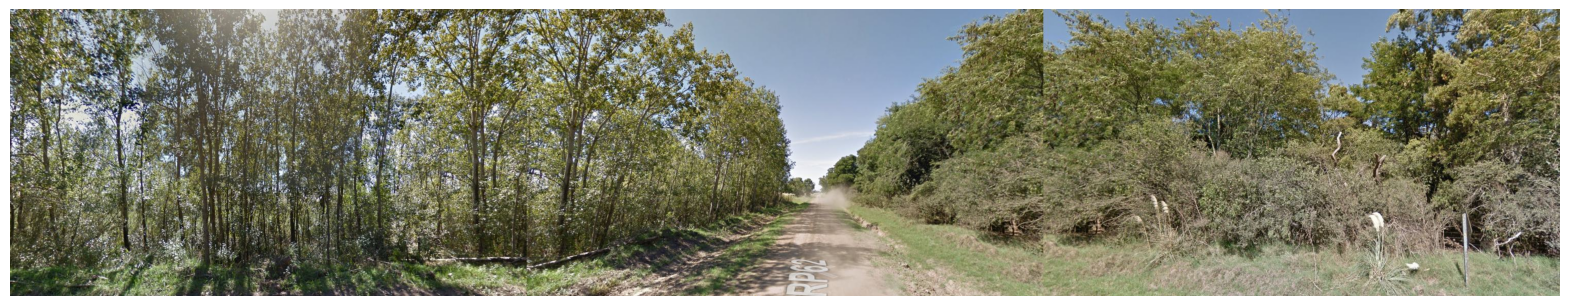

In [ ]:
# test KNN predictor

# select a random image
rand = random.randint(0,999)

# parse HuggingFace dataset
true_lat = row0.iloc[rand]['latitude']
true_lon = row0.iloc[rand]['longitude']
img = row0.iloc[rand]['image'] # image is stored as a byte encoding
address = row0.iloc[rand]['address']

# generate image embedding
embedding = embed_image(img['bytes']).numpy()

# run KNN 
pred_coords = knn_predict(embedding, k=5)

# create map
m = folium.Map(location=(true_lat, true_lon))

# add ground truth coordinates
folium.Marker(
    [true_lat, true_lon],
    popup="Ground Truth",
    icon=folium.Icon(color='blue', icon='info-sign')
).add_to(m)

# add predicted coordinates
folium.Marker(
    [pred_coords[0], pred_coords[1]],
    popup="Prediction",
    icon=folium.Icon(color='red', icon='info-sign')
).add_to(m)

print('pred coords', pred_coords[0],pred_coords[1])
print('true coords', float(true_lat), float(true_lon))
print('error (km)', haversine_distance(float(true_lat), float(true_lon), pred_coords[0],pred_coords[1]))

streetview = Image.open(io.BytesIO(img['bytes'])).convert('RGB')
plt.figure(figsize=(20, 10))
plt.imshow(streetview)
plt.axis('off')  # Hide the axes
plt.show()

# display map
m

In [21]:
# test KNN prediction on 10 random images from HuggingFace

total_error = np.zeros(10)

for i in range(10):
    rand = random.randint(0,999)

    # parse HuggingFace dataset
    true_lat = row0.iloc[rand]['latitude']
    true_lon = row0.iloc[rand]['longitude']
    img = row0.iloc[rand]['image'] # image is stored as a byte encoding
    address = row0.iloc[rand]['address']

    # generate image embedding
    embedding = embed_image(img['bytes']).numpy()

    # run KNN 
    pred_coords = knn_predict(embedding, k=5)

    print('pred',pred_coords[0],pred_coords[1])
    print('true',true_lat, true_lon)
    error = haversine_distance(pred_coords[0],pred_coords[1],float(true_lat), float(true_lon))
    total_error[i] = error
    print('error (km)',error)
    print('--------------')

print('average error (km)',np.mean(total_error))

pred -26.813282 150.33078
true -17.3952611 145.5195007
error (km) 1158.2498433847802
--------------
pred 15.084801 16.556944
true 27.4638542 90.5007355
error (km) 7681.936481173591
--------------
pred 52.494545 -1.4417015
true 51.6082289 -0.3641972
error (km) 123.0480176329505
--------------
pred 48.36911 11.073774
true 45.9590749 14.5493047
error (km) 375.2312221528283
--------------
pred 51.631805 5.470992
true 51.8064368 4.8818081
error (km) 44.99305311697066
--------------
pred 45.45933 8.202749
true 48.16878 18.8975629
error (km) 866.927798978298
--------------
pred 50.27748 10.239481
true 49.8393512 0.6661709
error (km) 684.6767765414261
--------------
pred -4.5928855 -21.44435
true -21.1330771 27.4307177
error (km) 5579.829538723341
--------------
pred 51.77119 5.0750456
true 49.5293837 0.6449253
error (km) 399.49665545991303
--------------
pred 37.235664 5.0707355
true 38.1692561 14.9329075
error (km) 873.4086700062863
--------------
average error (km) 1778.779805717039
